# Présentation des données

On cherche à généré des scénarios économiques. Plus précisément, on veut pour un actif $ (S_t)_{t \in \mathbb{N}} $ observé généré une série $ (\tilde{S}_h, \tilde{S}_{h+1} ... , \tilde{S}_{h+k})$ de variables dont la distribution est proche de \( (S_h, S_{h+1}, \ldots, S_{h+k}) \) (les vraies valeurs potentiellement observées).

On utilise donc des données sur le prix d'actifs financiers. Notre dataframe est composé de 36540 observations, 16 actifs financiers différents , ainsi que 2000 à 2500 observations par actif.

In [68]:
import pandas as pd
import numpy as np
from utils.create_data import simple_plot
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

In [6]:
df = pd.read_csv('./data/GANData.csv')
df.head(10)

,ASSETTYPE,ASSETSUBTYPE,ASSETNAME,ISHEDGED,INDEXPROXYNAME,VALUEDATE,PRICE
0,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36219,889.64
1,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36250,916.07
2,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36280,1006.43
3,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36311,983.72
4,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36341,1005.67
5,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36372,992.68
6,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36403,982.74
7,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36433,941.42
8,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36464,928.73
9,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36494,953.56


In [13]:
df.ASSETNAME.value_counts()

ASSETNAME
Europe ex UK Equity - USD Unhedged        2572
EUR Corporate Bond - USD Hedged           2528
Euro High Yield Bond BB-B - USD Hedged    2528
US Equity USD Unhedged                    2519
UK Equity - USD Unhedged                  2514
Global Property USD Unhedged              2507
Global Government Bond USD Hedged         2503
UK Government Bond - USD Hedged           2495
GBP Corporate Bond - USD Hedged           2483
Liquidity USD Unhedged                    2483
US Government Bond USD Unhedged           2439
USD Corporate Bond - USD Unhedged         2429
US High Yield Bond - USD Unhedged         2332
Liquidity EUR Unhedged in USD             2085
Liquidity GBP Unhedged in USD             1899
Infrastructure Debt - USD Unhedged         224
Name: count, dtype: int64

La variable ``VALUEDATE`` nous sert d'index pour chaque actif considéré. On a donc besoin seulement du prix ``PRICE`` et ``VALUEDATE`` pour construire nos séries temporelles

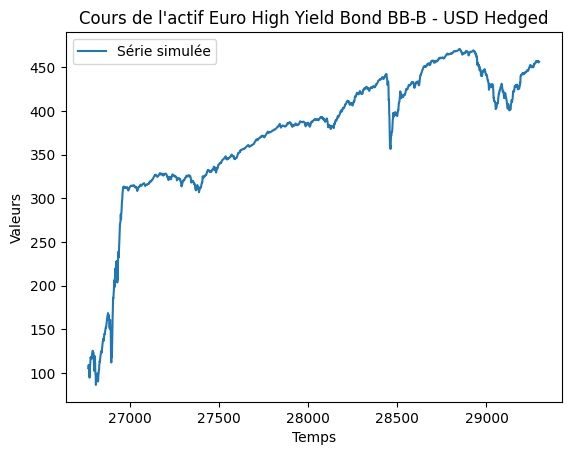

In [48]:
actif = "Euro High Yield Bond BB-B - USD Hedged"
simple_plot(df[df['ASSETNAME']==actif]['PRICE'], f"Cours de l'actif {actif}")

La série ne semble pas <u>stationnaire</u> (ie: $E(S_t)$ semble dépendre de t). Il sera donc compliqué de traité la série telle qu'elle dans un réseau de neuronne. On considère plutôt le LogReturn de la série, définie formellement par:

$ r_t = \ln\left(\frac{S_t}{S_{t-1}}\right) $

Où :
- $ S_t $ est le prix de l'actif à l'instant $ t $,
- $ \ln $ est la fonction logarithme naturel.

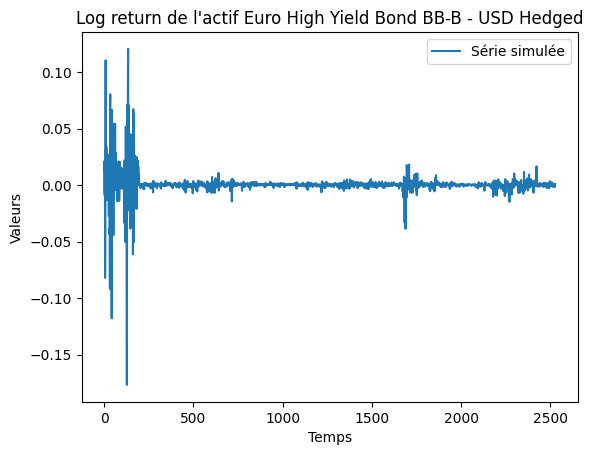

In [49]:
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")

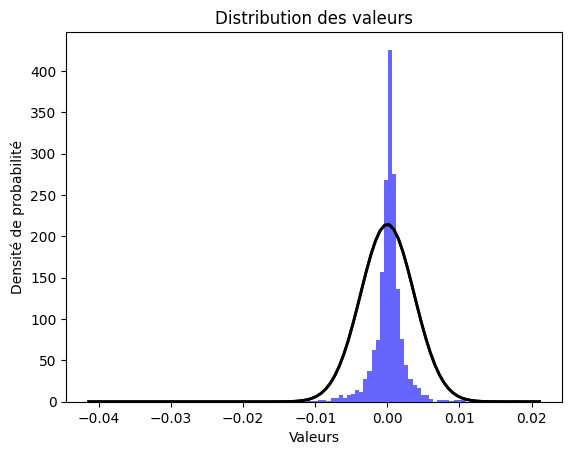

In [61]:
_y = y[200:] # On ne prends pas les 200 premières valeures car elles sont très très volatiles
y_sorted = np.sort(_y)

plt.hist(y_sorted, bins=100, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

p = np.exp(-0.5 * x**2/(2*np.var(_y))) / np.sqrt(np.var(_y) * np.pi)
plt.plot(x, p, 'k', linewidth=2)

plt.plot(x, p, 'k', linewidth=2)

plt.title('Distribution des valeurs')
plt.xlabel('Valeurs')
plt.ylabel('Densité de probabilité')
plt.show()

La distribution ressemble peut à la distribution d'une loi normale centrée de variance $\hat{V}(S), Les observations sont plus concentrées autour de la moyenne maisil exist aussi une queue plus importante pour la distribution empirique.

QQplot des log-returns


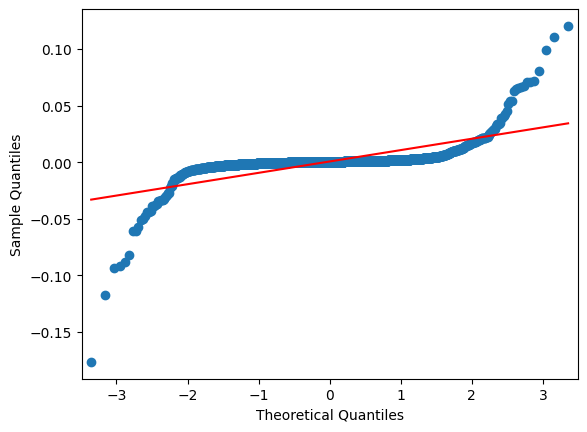

In [65]:
print('QQplot des log-returns')
qqplot(y, line='s')
plt.show()


La distribution des valeurs de la série ne colle pas très bien avec une loi normale, on peut chercher à transformer la série (retirer les outliers par exemple) afin que la distribution s'approche d'une loi normale et justifier ainsi l'utilisation de modèles statistiques. 

L'intérêt du projet ici est de ne pas dépendre d'hypothèses qui peuvent être parfois peu vraisemblables (normalité des logs-returns par exemple). En faisant le moins de transformations possibles à la série, on cherche à entraîner un modèle pour générer des séries de prix sans avoir à poser d'hypothèses statistiques au préalable. 